## データ準備

In [ ]:
import urllib.request
import sys

#ダウンロード
url = "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"
urllib.request.urlretrieve(url,"ldcc-20140209.tar.gz")
# 解凍
!tar xvf ldcc-20140209.tar.gz

In [2]:
import pandas as pd
import os
from glob import glob
import linecache

# カテゴリを配列で取得
categories = [name for name in os.listdir('text') if os.path.isdir(f'text/{name}')]
print('カテゴリ：', categories)

title_list = []
body_list = []
cat_list = []
for category in categories:
  path = f'text/{category}/*.txt'
  files = glob(path)
  for text_name in files:
    # 各テキストの3行目をリストに追加（タイトル）
    title_list.append(linecache.getline(text_name, 3))
    # 各テキストの4〜10行目をリストに追加（本文）
    body = ''
    for body_line in range(4, 10):
      body += linecache.getline(text_name, body_line)
    body_list.append(body)
    # 各テキストのカテゴリーをリストに追加
    cat_list.append(category)

cols = {'TITLE': title_list, 'BODY': body_list, 'CATEGORY': cat_list}
df = pd.DataFrame(cols)
df.head()

カテゴリ： ['kaden-channel', 'peachy', 'livedoor-homme', 'movie-enter', 'dokujo-tsushin', 'it-life-hack', 'smax', 'topic-news', 'sports-watch']


,TITLE,BODY,CATEGORY
0,五輪観戦しながらエクササイズ！ アルインコから室内フィットネス器具新発売【売れ筋チェック】\n,ロンドン五輪が開幕し、深夜にテレビ観戦して寝不足が続いている人も多いのではないだろうか。鍛え...,kaden-channel
1,次世代Xbox 720は年明けすぐに発表か？ この冬買いたいゲーム機をおさらいしよう【話題】\n,噂のマイクロソフト、次世代Xbox 720発表時期が早まったようだ。2012年の１月にCon...,kaden-channel
2,【記事連動】黒と白、ガンマの調整をするための オリジナルチャート【ビデオSALON】\n,ビデオサロン２月号P66-67の短期集中マスター\n「ソニーFS100Jで学ぶピクチャープロ...,kaden-channel
3,日テレで出る出る詐欺！ 出演を告知していた中島騒動の占い師が登場せず【話題】\n,日本テレビで放送された「芸能★BANG」、これは気になる芸能人のゴシップをレポーターや芸能記...,kaden-channel
4,一度は働いてみたい？ グーグル社のとにかくおしゃれなロンドンオフィスが話題に【話題】 \n,グーグル社のロンドンオフィスがおしゃれだと話題になっている。グーグルではエンジニアに素晴らし...,kaden-channel


## データを眺める

In [3]:
len(df)

7376

In [4]:
df['CATEGORY'].value_counts()

sports-watch      901
movie-enter       871
it-life-hack      871
smax              871
dokujo-tsushin    871
kaden-channel     865
peachy            843
topic-news        771
livedoor-homme    512
Name: CATEGORY, dtype: int64

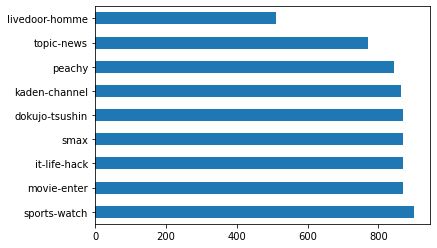

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df['CATEGORY'].value_counts().plot(kind='barh')

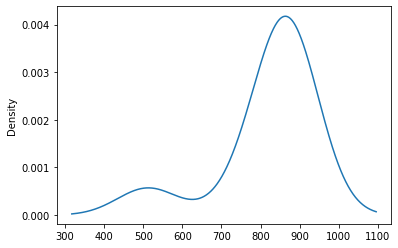

In [9]:
df['CATEGORY'].value_counts().plot.kde()

## 前処理

In [10]:
import re

def preprocessing(text):
  # 全角 => 半角
  text = text.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))
  # 英語大文字を小文字化
  text = text.lower()
  # 削除する文字列
  remove_list = ['\n', '　', ' ']
  for rem_word in remove_list:
    text = text.replace(rem_word, '')
  # 数字列を0に置換
  text = re.sub('[0-9]+', '0', text)

  return text

In [11]:
df['TITLE'] = df['TITLE'].map(preprocessing)

In [12]:
df.head()

,TITLE,BODY,CATEGORY
0,五輪観戦しながらエクササイズ!アルインコから室内フィットネス器具新発売【売れ筋チェック】,ロンドン五輪が開幕し、深夜にテレビ観戦して寝不足が続いている人も多いのではないだろうか。鍛え...,kaden-channel
1,次世代xbox0は年明けすぐに発表か?この冬買いたいゲーム機をおさらいしよう【話題】,噂のマイクロソフト、次世代Xbox 720発表時期が早まったようだ。2012年の１月にCon...,kaden-channel
2,【記事連動】黒と白、ガンマの調整をするためのオリジナルチャート【ビデオsalon】,ビデオサロン２月号P66-67の短期集中マスター\n「ソニーFS100Jで学ぶピクチャープロ...,kaden-channel
3,日テレで出る出る詐欺!出演を告知していた中島騒動の占い師が登場せず【話題】,日本テレビで放送された「芸能★BANG」、これは気になる芸能人のゴシップをレポーターや芸能記...,kaden-channel
4,一度は働いてみたい?グーグル社のとにかくおしゃれなロンドンオフィスが話題に【話題】,グーグル社のロンドンオフィスがおしゃれだと話題になっている。グーグルではエンジニアに素晴らし...,kaden-channel


## Mecabインストール

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n

!sed -e "s!/var/lib/mecab/dic/debian!/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd!g" /etc/mecabrc &gt; /etc/mecabrc.new
!cp /etc/mecabrc /etc/mecabrc.org
!cp /etc/mecabrc.new /etc/mecabrc

## 分かち書き

In [14]:
import MeCab

def tokenize(text, target_pos=['名詞', '形容詞', '形容動詞', '動詞', '副詞']):
  tokens = []
  mecab = MeCab.Tagger ('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')
  mecab.parse('') #文字列がGCされるのを防ぐ
  node = mecab.parseToNode(text)
  while node:
    #単語を取得
    word = node.surface
    #品詞を取得
    pos = node.feature.split(",")[0]
    # 名詞の場合のみ抽出
    if pos in target_pos:
      tokens.append(word)
    #次の単語に進める
    node = node.next
  return tokens

In [77]:
df['TITLE_WAKATI'] = df['TITLE'].map(lambda x: ' '.join(tokenize(x)))
df.head()

,TITLE,BODY,CATEGORY,TITLE_WAKATI,CATEGORY_CODE
0,五輪観戦しながらエクササイズ!アルインコから室内フィットネス器具新発売【売れ筋チェック】,ロンドン五輪が開幕し、深夜にテレビ観戦して寝不足が続いている人も多いのではないだろうか。鍛え...,kaden-channel,五輪 観戦 し エクササイズ アルインコ 室内 フィットネス 器具 新発売 売れ筋 チェック,0
1,次世代xbox0は年明けすぐに発表か?この冬買いたいゲーム機をおさらいしよう【話題】,噂のマイクロソフト、次世代Xbox 720発表時期が早まったようだ。2012年の１月にCon...,kaden-channel,次世代 xbox 0 年明け すぐ 発表 冬 買い ゲーム機 おさらい しよう 話題,0
2,【記事連動】黒と白、ガンマの調整をするためのオリジナルチャート【ビデオsalon】,ビデオサロン２月号P66-67の短期集中マスター\n「ソニーFS100Jで学ぶピクチャープロ...,kaden-channel,記事 連動 黒 白 ガンマ 調整 する ため オリジナル チャート ビデオsalon,0
3,日テレで出る出る詐欺!出演を告知していた中島騒動の占い師が登場せず【話題】,日本テレビで放送された「芸能★BANG」、これは気になる芸能人のゴシップをレポーターや芸能記...,kaden-channel,日テレ 出る 出る 詐欺 出演 告知 し い 中島 騒動 占い師 登場 せ 話題,0
4,一度は働いてみたい?グーグル社のとにかくおしゃれなロンドンオフィスが話題に【話題】,グーグル社のロンドンオフィスがおしゃれだと話題になっている。グーグルではエンジニアに素晴らし...,kaden-channel,一 度 働い み グーグル 社 とにかく おしゃれ ロンドン オフィス 話題 話題,0


## 目的変数をIDに変換

In [16]:
ctgs_dict = {}
for idx, ctg in enumerate(categories):
  ctgs_dict[ctg] = idx

df['CATEGORY_CODE'] = df['CATEGORY'].map(ctgs_dict)
df[::777]

,TITLE,BODY,CATEGORY,TITLE_WAKATI,CATEGORY_CODE
0,五輪観戦しながらエクササイズ!アルインコから室内フィットネス器具新発売【売れ筋チェック】,ロンドン五輪が開幕し、深夜にテレビ観戦して寝不足が続いている人も多いのではないだろうか。鍛え...,kaden-channel,五輪 観戦 し エクササイズ アルインコ 室内 フィットネス 器具 新発売 売れ筋 チェック,0
777,ボディソニック座イス—ナップ・ファンソニックマンボウソファ【売れ筋チェック】,節電暖房器具としてコタツが注目されているが、長時間そこで温まるからこそ、座イスにもとことんこ...,kaden-channel,ボディソニック 座 イス ナップ・ファンソニックマンボウソファ 売れ筋 チェック,0
1554,ショコラファンの為のチョコレートの祭典「サロン・デュ・ショコラ」が開催,毎年パリで開催されショコラファンを魅了するチョコレートの祭典である「サロン・デュ・ショコラ...,peachy,ショコラ ファン 為 チョコレート 祭典 サロン・デュ・ショコラ 開催,1
2331,剛力彩芽が収録現場でハプニング「夢は宇宙人になること!」,『エイリアン』『グラディエーター』など映画史上において幾多の金字塔を打ち建ててきた、生きる...,movie-enter,剛力彩芽 収録 現場 ハプニング 夢 宇宙人 なる こと,3
3108,もし身近な男性がタイガーマスクだったら?,昨年のクリスマスに「伊達直人」名義で児童養護施設へランドセルが届けられた、という報道が発端に...,dokujo-tsushin,もし 身近 男性 タイガーマスク,4
3885,独女的ブックレビュー『「ゆるオタ君」と結婚しよう』,婚活に疲れ気味、あるいは「いい男がいない」「出会いがない」が口癖の独女にお薦めしたいのが、マ...,dokujo-tsushin,独女 的 ブックレビュー ゆるオタ 君 結婚 しよう,4
4662,0gbのbdxl対応ドライブが登場!最小・最軽量のポータブルドライブ,PC向けのポータブル外付けドライブとしては世界最小・最軽量を謳う製品がバッファローより登場。...,it-life-hack,0g b bdxl 対応 ドライブ 登場 最小 軽量 ポータブル ドライブ,5
5439,0.0ghzクアッドコアcpu搭載!超ハイスペックandroidタブレット「asustran...,ASUS Transformer Pad Infinity TF700Tを購入！ \n\nA...,smax,0 0g hz クアッドコア cpu 搭載 ハイスペック android タブレット asu...,6
6216,深澤真紀さん「“草食系男子”という言葉を作り申し訳なく思う」,“草食系男子”という言葉は、2009年度の新語・流行語大賞のトップテンに選ばれ、日本社会でも...,topic-news,深澤真紀 さん 草食系男子 言葉 作り 申し訳なく 思う,7
6993,【sportswatch】星野楽天、今オフに再び大型補強の噂,ペナントレースも大詰めを迎えているプロ野球界だが、盛り上がっている様子がいまいち伝わってこな...,sports-watch,sports watch 星野 楽天 オフ 再び 大型 補強 噂,8


## 単語埋め込みのために、学習・検証・テストに分割

In [17]:
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(df, test_size=0.2, random_state=144, stratify=df['CATEGORY_CODE'])
valid, test = train_test_split(valid_test, test_size=0.5, random_state=144, stratify=valid_test['CATEGORY_CODE'])

# 事例数の確認
print('===学習データ===')
print(train['CATEGORY_CODE'].value_counts())
print('===検証データ===')
print(valid['CATEGORY_CODE'].value_counts())
print('===評価データ===')
print(test['CATEGORY_CODE'].value_counts())

===学習データ===
8    720
3    697
6    697
5    697
4    697
0    692
1    674
7    617
2    409
Name: CATEGORY_CODE, dtype: int64
===検証データ===
8    90
6    87
5    87
4    87
3    87
0    86
1    85
7    77
2    52
Name: CATEGORY_CODE, dtype: int64
===評価データ===
8    91
6    87
5    87
4    87
3    87
0    87
1    84
7    77
2    51
Name: CATEGORY_CODE, dtype: int64


## Word2Vecによる単語埋め込み

In [18]:
wakati = train[['TITLE_WAKATI']]
wakati.to_csv('wakati.csv', sep='\n', header=True, index=False)
wakati

,TITLE_WAKATI
3380,やっぱり お金持ち 結婚 し
456,連載 極 ト書き 一 行 カット 割り 0回 ビデオsalon
1890,注目 セレクトショップ バイヤー 聞く ファッション 業界 裏バナシ
5604,パナソニック 新しい ブランド 機能 高性能 foma スマホ elugavp 0 d 特集
2767,女子大生 体 張っ 東京国際映画祭 告知
...,...
4983,リアル 役立つ 美味しい ビール 注ぎ 方 マスター できる ビール 黄金 比率 iphon...
5548,ついに ios版 配信 開始 三面記事 的 ニュース サクッと チェック できる 三面 貴族...
4841,サムスン電子 nttドコモ 向け galaxynotesc 0 d and roi d0 0...
898,インタビュー 大井真理子 さん 経済 わかる 絶対 強い


In [ ]:
from gensim.models import word2vec
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
sentence_data = word2vec.LineSentence('wakati.csv')
vectorizer = word2vec.Word2Vec(sentence_data,
                         sg=1,        # Skip-gram
                         size=200,    # 次元数
                         min_count=1, # min_count回未満の単語を破棄
                         window=3,    # 文脈の最大単語数
                         hs=1,        # 階層ソフトマックス(ネガティブサンプリングするなら0)
                         negative=5,  # ネガティブサンプリング
                         iter=50      # Epoch数
                         )

In [20]:
vectorizer.most_similar('映画')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2021-06-21 13:07:44,208 : INFO : precomputing L2-norms of word weight vectors


[('マイ・ビッグ・ファット・ウェディング', 0.49575042724609375),
 ('部', 0.4737938642501831),
 ('大杉漣', 0.4730076193809509),
 ('tiff', 0.4707191288471222),
 ('gogw', 0.46691828966140747),
 ('抜擢', 0.45512598752975464),
 ('すてき', 0.4541832506656647),
 ('綾瀬はるか', 0.4539102017879486),
 ('精子バンク', 0.4484458565711975),
 ('ねごと', 0.4477579593658447)]

## 単語埋め込みから特徴ベクトル作成

In [21]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [vectorizer[word] for word in words if word in vectorizer]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [22]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE_WAKATI']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE_WAKATI']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE_WAKATI']])

print(X_train.size())
print(X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


torch.Size([5900, 200])
tensor([[ 0.2483, -0.5716, -0.4387,  ...,  0.1442,  0.0408, -0.1703],
        [ 0.4662,  0.0948,  0.3693,  ..., -0.0928,  0.4833, -0.0487],
        [-0.0558, -0.3060, -0.2442,  ..., -0.1102, -0.2541, -0.0646],
        ...,
        [ 0.2470,  0.1478, -0.0585,  ..., -0.3463,  0.1212,  0.1382],
        [-0.1154,  0.2898, -0.1179,  ...,  0.1844,  0.0927, -0.3289],
        [ 0.0488, -0.5713,  0.1610,  ..., -0.3007,  0.1320,  0.1958]])


## ラベルベクトルの作成

In [23]:
y_train = torch.tensor(train['CATEGORY_CODE'].values)
y_valid = torch.tensor(valid['CATEGORY_CODE'].values)
y_test = torch.tensor(test['CATEGORY_CODE'].values)

print(y_train.size())
print(y_train)

torch.Size([5900])
tensor([4, 0, 2,  ..., 6, 1, 3])


## 学習 => 予測 => 精度評価

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def learn_pred_accuracy(clf, train_x, train_y, valid_x, valid_y, test_x, test_y):
  # 学習
  clf.fit(train_x, train_y)
  # 予測
  predict_vy = clf.predict(valid_x)
  predict_y = clf.predict(test_x)
  # 正解率
  print('検証True:', np.count_nonzero(predict_vy == valid_y))
  print('検証False:', np.count_nonzero(predict_vy != valid_y))
  print('検証正解率:', np.count_nonzero(predict_vy == valid_y) / len(valid_y))
  print('テストTrue:', np.count_nonzero(predict_y == test_y))
  print('テストFalse:', np.count_nonzero(predict_y != test_y))
  print('テスト正解率:', np.count_nonzero(predict_y == test_y) / len(test_y))
  # 様々な精度結果
  print(classification_report(test_y, predict_y))
  # 正解と予測データ
  print('検証正解：', valid_y[:20])
  print('検証予測：', predict_vy[:20])
  print('test正解：', test_y[:20])
  print('test予測：', predict_y[:20])
  # 予測データのヒストグラム
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  sns.countplot(x=predict_vy, ax=ax1)
  sns.countplot(x=predict_y, ax=ax2)
  # 混合行列
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
  cm = confusion_matrix(valid_y, predict_vy)
  sns.heatmap(cm, cmap='jet', annot=True, ax=ax1)
  cm = confusion_matrix(test_y, predict_y)
  sns.heatmap(cm, cmap='jet', annot=True, ax=ax2)

## Naive Bayes

検証True: 469
検証False: 269
検証正解率: 0.6355013550135501
テストTrue: 480
テストFalse: 258
テスト正解率: 0.6504065040650406
              precision    recall  f1-score   support

           0       0.59      0.63      0.61        87
           1       0.55      0.55      0.55        84
           2       0.93      0.25      0.40        51
           3       0.62      0.79      0.69        87
           4       0.59      0.68      0.63        87
           5       0.57      0.63      0.60        87
           6       0.66      0.68      0.67        87
           7       0.75      0.70      0.72        77
           8       0.91      0.77      0.83        91

    accuracy                           0.65       738
   macro avg       0.68      0.63      0.63       738
weighted avg       0.67      0.65      0.65       738

検証正解： [3 1 0 1 5 6 1 8 4 5 0 5 6 0 4 0 4 6 8 7]
検証予測： [3 1 0 1 5 6 4 8 3 3 5 5 6 0 4 0 4 6 8 7]
test正解： [0 8 3 3 2 4 6 0 1 5 0 7 8 2 0 8 7 3 7 8]
test予測： [0 8 3 3 1 4 6 0 3 3 4 7 8 3 5 8 7 3

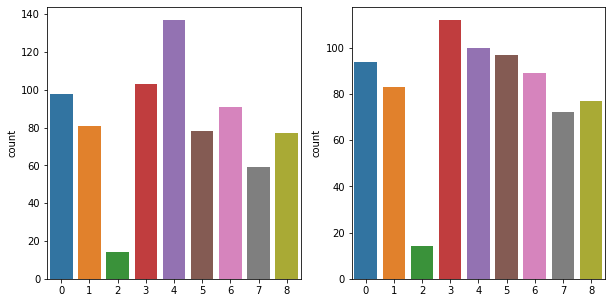

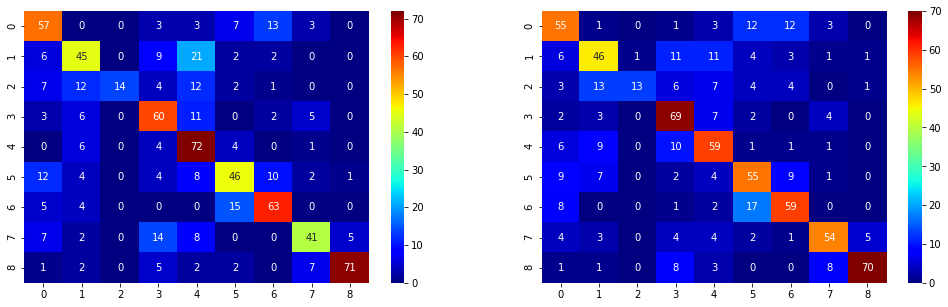

In [63]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn import preprocessing

clf = MultinomialNB(alpha=.01)
mm = preprocessing.MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)
X_valid_mm = mm.transform(X_valid)
X_test_mm = mm.transform(X_test)
mm = preprocessing.MinMaxScaler()
learn_pred_accuracy(clf, X_train_mm, y_train, X_valid_mm, np.array(y_valid), X_test_mm, np.array(y_test))

## Decision Tree Classifier

検証True: 380
検証False: 358
検証正解率: 0.5149051490514905
テストTrue: 366
テストFalse: 372
テスト正解率: 0.4959349593495935
              precision    recall  f1-score   support

           0       0.43      0.47      0.45        87
           1       0.41      0.42      0.41        84
           2       0.42      0.39      0.40        51
           3       0.42      0.43      0.42        87
           4       0.45      0.44      0.44        87
           5       0.51      0.51      0.51        87
           6       0.65      0.68      0.66        87
           7       0.40      0.42      0.41        77
           8       0.74      0.66      0.70        91

    accuracy                           0.50       738
   macro avg       0.49      0.49      0.49       738
weighted avg       0.50      0.50      0.50       738

検証正解： [3 1 0 1 5 6 1 8 4 5 0 5 6 0 4 0 4 6 8 7]
検証予測： [2 0 0 3 3 6 3 8 3 0 5 5 0 8 1 0 3 6 8 7]
test正解： [0 8 3 3 2 4 6 0 1 5 0 7 8 2 0 8 7 3 7 8]
test予測： [2 8 0 3 1 4 6 0 4 3 7 5 7 0 6 8 5 4

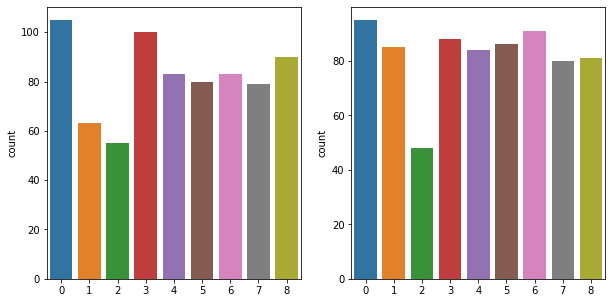

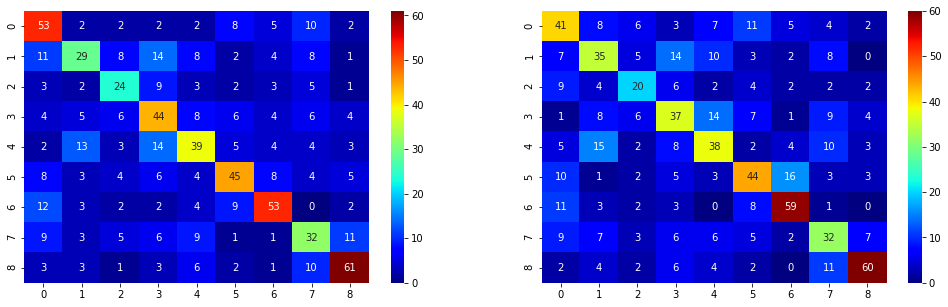

In [64]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=144)
learn_pred_accuracy(clf, X_train, y_train, X_valid, np.array(y_valid), X_test, np.array(y_test))

## XGBoost

検証True: 524
検証False: 214
検証正解率: 0.7100271002710027
テストTrue: 519
テストFalse: 219
テスト正解率: 0.7032520325203252
              precision    recall  f1-score   support

           0       0.70      0.75      0.72        87
           1       0.53      0.62      0.57        84
           2       0.82      0.45      0.58        51
           3       0.67      0.80      0.73        87
           4       0.76      0.61      0.68        87
           5       0.67      0.66      0.66        87
           6       0.73      0.86      0.79        87
           7       0.72      0.62      0.67        77
           8       0.85      0.84      0.84        91

    accuracy                           0.70       738
   macro avg       0.72      0.69      0.69       738
weighted avg       0.71      0.70      0.70       738

検証正解： [3 1 0 1 5 6 1 8 4 5 0 5 6 0 4 0 4 6 8 7]
検証予測： [3 3 0 0 5 6 1 8 1 3 5 5 6 0 4 0 1 6 8 7]
test正解： [0 8 3 3 2 4 6 0 1 5 0 7 8 2 0 8 7 3 7 8]
test予測： [0 8 3 3 1 4 6 0 1 3 4 5 8 3 6 8 7 3

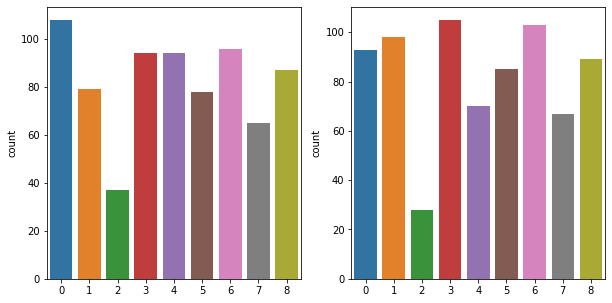

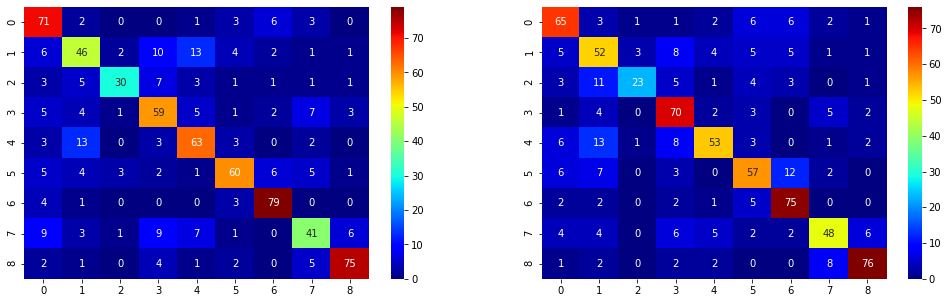

In [65]:
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=144, objective='binary:logistic')
learn_pred_accuracy(clf, X_train, y_train, X_valid, np.array(y_valid), X_test, np.array(y_test))

## ロジスティック回帰

検証True: 539
検証False: 199
検証正解率: 0.7303523035230353
テストTrue: 563
テストFalse: 175
テスト正解率: 0.7628726287262872
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        87
           1       0.71      0.67      0.69        84
           2       0.67      0.55      0.60        51
           3       0.75      0.83      0.79        87
           4       0.75      0.69      0.72        87
           5       0.72      0.79      0.75        87
           6       0.84      0.91      0.87        87
           7       0.79      0.70      0.74        77
           8       0.85      0.84      0.84        91

    accuracy                           0.76       738
   macro avg       0.76      0.75      0.75       738
weighted avg       0.76      0.76      0.76       738

検証正解： [3 1 0 1 5 6 1 8 4 5 0 5 6 0 4 0 4 6 8 7]
検証予測： [3 2 0 2 5 6 2 8 3 3 5 5 5 0 4 0 3 6 8 7]
test正解： [0 8 3 3 2 4 6 0 1 5 0 7 8 2 0 8 7 3 7 8]
test予測： [0 8 3 3 2 4 6 0 1 2 4 7 8 3 6 8 7 3

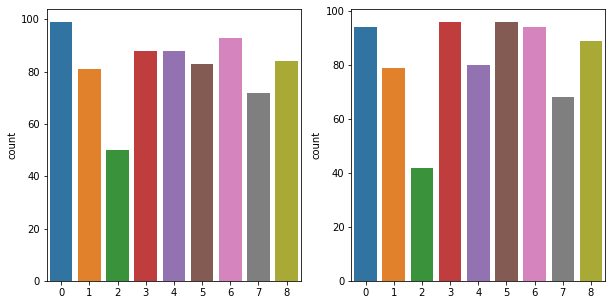

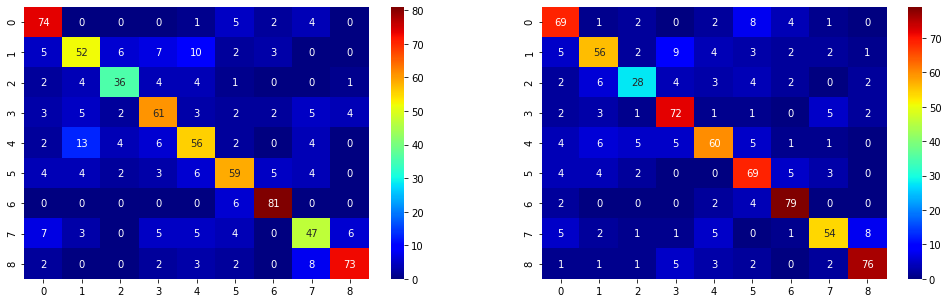

In [66]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=144, max_iter=144000)
learn_pred_accuracy(clf, X_train, y_train, X_valid, np.array(y_valid), X_test, np.array(y_test))

## LSTM

In [120]:
# バッチサイズを1とする
"""
X_train = X_train.view(len(X_train), 1, -1)
X_valid = X_valid.view(len(X_valid), 1, -1)
X_test = X_test.view(len(X_test), 1, -1)

print('X_train:', X_train.size())
print('X_valid:', X_valid.size())
print('X_test:', X_test.size())
"""

X_train: torch.Size([5900, 1, 200])
X_valid: torch.Size([738, 1, 200])
X_test: torch.Size([738, 1, 200])


In [67]:
import torch
import torch.nn as nn

# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMClassifier(nn.Module):
  # モデルで使う各ネットワークをコンストラクタで定義
  def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
    # 親クラスのコンストラクタ。決まり文句
    super(LSTMClassifier, self).__init__()
    # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
    self.hidden_dim = hidden_dim
    # インプットの単語をベクトル化するために使う
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    # LSTMの隠れ層。これ１つでOK。超便利。
    self.lstm = nn.LSTM(embedding_dim, hidden_dim)
    # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
    self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
    # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
    self.softmax = nn.LogSoftmax(dim=1)

  # 順伝播処理はforward関数に記載
  def forward(self, sentence):
    # 文章内の各単語をベクトル化して出力。2次元のテンソル
    embeds = self.word_embeddings(sentence)
    # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
    # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
    _, lstm_out = self.lstm(embeds.view(len(sentence), 1, -1))
    # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
    tag_space = self.hidden2tag(lstm_out[0].view(-1, self.hidden_dim))
    # softmaxに食わせて、確率として表現
    tag_scores = self.softmax(tag_space)
    return tag_scores

In [74]:
import torch.optim as optim

# trainとtestに分割
traindata, testdata = train_test_split(df, train_size=0.8)
# 単語のベクトル次元数
EMBEDDING_DIM = 10
# 隠れ層の次元数
HIDDEN_DIM = 128
# データ全体の単語数
VOCAB_SIZE = len(word2index)
# 分類先のカテゴリの数
TAG_SIZE = len(categories)
# モデル宣言
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
loss_function = nn.NLLLoss()
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
optimizer = optim.SGD(model.parameters(), lr=0.01)

def make_wakati(sentence):
  # MeCabで分かち書き
  mecab = MeCab.Tagger ('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')
  mecab.parse('') #文字列がGCされるのを防ぐ
  sentence = mecab.parse(sentence)
  # 半角全角英数字除去
  sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
  # 記号もろもろ除去
  sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
  # スペースで区切って形態素の配列へ
  wakati = sentence.split(" ")
  # 空の要素は削除
  wakati = list(filter(("").__ne__, wakati))
  return wakati

# 単語ID辞書を作成する
word2index = {}
for title in df['TITLE']:
  wakati = make_wakati(title)
  for word in wakati:
    if word in word2index: continue
    word2index[word] = len(word2index)

# 文章を単語IDの系列データに変換
# PyTorchのLSTMのインプットになるデータなので、もちろんtensor型で
def sentence2index(sentence):
  wakati = make_wakati(sentence)
  return torch.tensor([word2index[w] for w in wakati], dtype=torch.long)

category2index = {}
for cat in categories:
  if cat in category2index: continue
  category2index[cat] = len(category2index)

def category2tensor(cat):
  return torch.tensor([category2index[cat]], dtype=torch.long)

# 各エポックの合計loss値を格納する
losses = []
# 10ループ回してみる。（バッチ化とかGPU使ってないので結構時間かかる...）
for epoch in range(10):
    all_loss = 0
    for title, cat in zip(traindata['TITLE'], traindata['CATEGORY']):
        # モデルが持ってる勾配の情報をリセット
        model.zero_grad()
        # 文章を単語IDの系列に変換（modelに食わせられる形に変換）
        inputs = sentence2index(title)
        # 順伝播の結果を受け取る
        out = model(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        all_loss += loss.item()
    losses.append(all_loss)
    print('epoch', epoch, '\t' , 'loss', all_loss)
print('done.')

epoch 0 	 loss 12321.468370690942
epoch 1 	 loss 10722.16016432643
epoch 2 	 loss 10180.66920878482
epoch 3 	 loss 9999.271032893448
epoch 4 	 loss 9816.490174383041
epoch 5 	 loss 9666.416423010058
epoch 6 	 loss 9529.215358903195
epoch 7 	 loss 9403.004448020947
epoch 8 	 loss 9286.00225551473
epoch 9 	 loss 9173.927343069823
done.


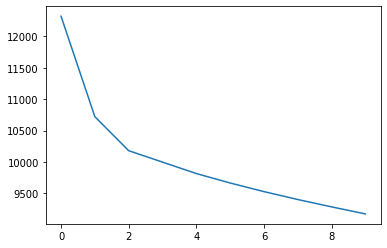

In [75]:
plt.plot(losses)

In [76]:
# テストデータの母数計算
test_num = len(testdata)
# 正解の件数
a = 0
# 勾配自動計算OFF
with torch.no_grad():
    for title, category in zip(testdata['TITLE'], testdata['CATEGORY']):
        # テストデータの予測
        inputs = sentence2index(title)
        out = model(inputs)

        # outの一番大きい要素を予測結果をする
        _, predict = torch.max(out, 1)

        answer = category2tensor(category)
        if predict == answer:
            a += 1
print("predict : ", a / test_num)

predict :  0.3970189701897019
